# Example Tutorial for Extracting the Clusters for T4 Lysozyme

In this short tutorial we assume that you have already calculated the important
internal coordinates (e.g. contact distances).
We did that and provide a file with every 1000th frame of the 402 contact 
distance from [Ernst17].
Keep in mind that we do not distinguish between correlation and 
anti-correlation so that the resulting values are always between 0 and 1.

Additionally, we need an index-file, in which the columns of the coordinate
file are specified. For example, the first line contains only 
> 1 5 

which means, that the first column in the coordinate file corresponds to the 
minimal distance between the first and fifth residue.


In [1]:
import mosaic
import numpy as np


internal_coords = np.loadtxt('./../../plots/t4l_final/github_example_t4l.dat')
internal_coords_names = np.loadtxt('../../plots/t4l_final/t4l_coordinate_names.idx')

sim = mosaic.Similarity(metric='correlation')
sim.fit(internal_coords)
correlation_matrix = sim.matrix_
print(correlation_matrix)

[[1.00000000e+00 4.49446002e-01 7.55899345e-01 ... 8.54533790e-02
  2.54271209e-02 1.52529918e-02]
 [4.49446002e-01 1.00000000e+00 6.55461330e-01 ... 1.44750560e-02
  5.71526116e-04 3.00258687e-02]
 [7.55899345e-01 6.55461330e-01 1.00000000e+00 ... 1.02415864e-01
  3.82059353e-02 7.74224217e-03]
 ...
 [8.54533790e-02 1.44750560e-02 1.02415864e-01 ... 1.00000000e+00
  7.18579325e-03 1.08971096e-01]
 [2.54271209e-02 5.71526116e-04 3.82059353e-02 ... 7.18579325e-03
  1.00000000e+00 3.79683010e-02]
 [1.52529918e-02 3.00258687e-02 7.74224217e-03 ... 1.08971096e-01
  3.79683010e-02 1.00000000e+00]]


## Clustering 

Using this correlation matrix, we continue to compute the clusters using the 
Leiden algorithm with the constant Potts model. In this example, we will use
a resolution parameter of gamma=0.5.
For large matrices, we could also use a cutoff so that we mask all correlation 
entries below a certain threshold.

In [ ]:
clustering = mosaic.Clustering(
    mode='CPM',
    weighted=True,
    resolution_parameter=0.5,
)
clustering.fit(correlation_matrix)

After the clustering (which can take a while, depending on the size of the 
matrix), we want to take a look at the matrix.

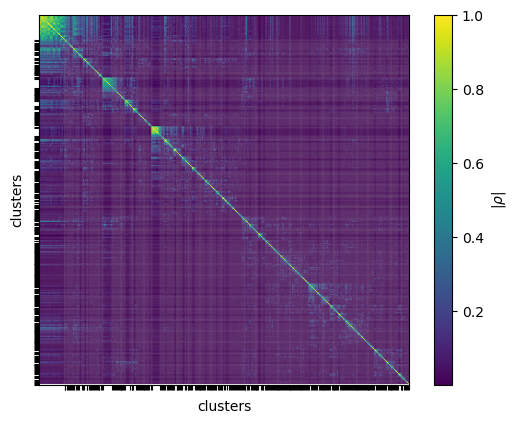

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(clustering.matrix_)
ax.set_xticks(clustering.ticks_)
ax.set_yticks(clustering.ticks_)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('clusters')
ax.set_ylabel('clusters')
ax.grid(visible=True, linewidth=0.1)
plt.colorbar(im, label=r'$|\rho|$')
plt.show()

Sometimes, we rather want to sort the clusters by size: 

In [48]:
idxs = np.argsort(
    [len(cluster) for cluster in clustering.clusters_],
)[::-1]
clusters_sorted = np.concatenate(clustering.clusters_[idxs])

# sort the matrix accordingly
matrix_sorted = correlation_matrix[np.ix_(clusters_sorted, clusters_sorted)]
ticks = np.cumsum([len(cluster) for cluster in clustering.clusters_[idxs]])

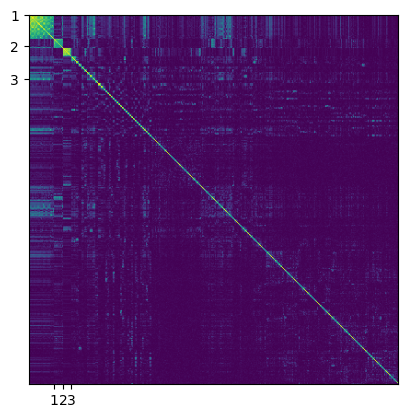

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(matrix_sorted)
ax.set_xticks(ticks[:3])
ax.set_yticks(ticks[:3])
ax.set_xticklabels(np.arange(3)+1)
ax.set_yticklabels(np.arange(3)+1)
plt.show()